<a href="https://colab.research.google.com/github/Coffinbrain/lessons/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 

In [ ]:
import os
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import classification_report, accuracy_score
import wandb
import matplotlib.pyplot as plt

In [ ]:
# Enable more detailed error messages for CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Connect to the SQLite database
db_path = r'/content/drive/MyDrive/Colab Notebooks/IMDB/IMDB_Movies_2021.db'
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file not found at {db_path}")
conn = sqlite3.connect(db_path)
# Load the data into a DataFrame
df = pd.read_sql_query("SELECT AUTHOR, TITLE, REVIEW, RATING FROM REVIEWS", conn)
conn.close()

In [ ]:
# Data preprocessing
df = df.dropna(subset=['RATING'])
df['RATING'] = df['RATING'].astype(float).round().astype(int)
df['REVIEW'] = df['REVIEW'].astype(str)
# Check and adjust label range if necessary
min_rating = df['RATING'].min()
df['RATING'] = df['RATING'] - min_rating  # Adjust labels to start from 0

# Verify the range of labels
print(f"Unique labels: {df['RATING'].unique()}")

# Split the data (stratified split)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['RATING'])
train_df, eval_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['RATING'])

# Print information about train and eval data
print(f"Train data shape: {train_df.shape}")
print(f"Evaluation data shape: {eval_df.shape}")

Unique labels: [4 7 3 5 8 6 2 0 1 9]
Train data shape: (2985, 4)
Evaluation data shape: (747, 4)


In [ ]:
# 设置 W&B 项目名称
wandb_project_name = "imdb_visualization_of_results_epochs=10"  # 请将其替换为您的 W&B 项目名称

# 初始化 W&B
wandb.init(project=wandb_project_name)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# 设置训练参数
model_args = {
    "num_train_epochs": 10,
    "train_batch_size": 64,
    "learning_rate": 1e-5,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "wandb_project": wandb_project_name  # 设置 W&B 项目名称
}

In [ ]:
# 初始化模型
model = ClassificationModel("roberta", "roberta-base", num_labels=df['RATING'].nunique(), args=model_args,
                            use_cuda=True)

train_accuracy_list = []
eval_accuracy_list = []
epochs_list = []

for epoch in range(model_args["num_train_epochs"]):
    print(f"Epoch: {epoch + 1}")
    model.train_model(train_df[['REVIEW', 'RATING']])

    # 计算训练准确度
    train_preds, _ = model.predict(train_df['REVIEW'].tolist())
    train_accuracy = accuracy_score(train_df['RATING'], train_preds)
    train_accuracy_list.append(train_accuracy)

    # 计算验证集准确度
    eval_preds, _ = model.predict(eval_df['REVIEW'].tolist())
    eval_accuracy = accuracy_score(eval_df['RATING'], eval_preds)
    eval_accuracy_list.append(eval_accuracy)

    epochs_list.append(epoch + 1)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Evaluation Accuracy: {eval_accuracy}")

    # 记录训练指标到 W&B
    wandb.log({"epoch": epoch + 1, "training_accuracy": train_accuracy, "evaluation_accuracy": eval_accuracy})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,▁
global_step,▁
lr,▁
Training loss,2.26782
global_step,50
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.5222780569514238
Evaluation Accuracy: 0.3949129852744311
Epoch: 2


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,█▆▂▃▂▂▂▂▁
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,1.31431
epoch,1
evaluation_accuracy,0.39491
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.7688442211055276
Evaluation Accuracy: 0.3989290495314592
Epoch: 3


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,▆█▆▆▄▁▃▂▂
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.84299
epoch,2
evaluation_accuracy,0.39893
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9105527638190954
Evaluation Accuracy: 0.38018741633199465
Epoch: 4


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,█▅▅▄▂▄▃▂▁
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.42218
epoch,3
evaluation_accuracy,0.38019
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9728643216080402
Evaluation Accuracy: 0.37215528781793844
Epoch: 5


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,█▅▅▅▂▄▁▁▂
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.26688
epoch,4
evaluation_accuracy,0.37216
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9949748743718593
Evaluation Accuracy: 0.37349397590361444
Epoch: 6


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,█▄▅▄▆▁▄▂▂
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.15893
epoch,5
evaluation_accuracy,0.37349
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.998324958123953
Evaluation Accuracy: 0.36947791164658633
Epoch: 7


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,▅▅▅█▃▃▆▁▄
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.07545
epoch,6
evaluation_accuracy,0.36948
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9996649916247906
Evaluation Accuracy: 0.3708165997322624
Epoch: 8


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,▅█▃▂▁▁▂▂▂
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.04198
epoch,7
evaluation_accuracy,0.37082
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9996649916247906
Evaluation Accuracy: 0.37617135207496655
Epoch: 9


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,█▇▁▃▃▂▃▁█
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.05719
epoch,8
evaluation_accuracy,0.37617
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9996649916247906
Evaluation Accuracy: 0.3788487282463186
Epoch: 10


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training loss,▂▂▂█▁▂▁▁▁
epoch,▁
evaluation_accuracy,▁
global_step,▁▂▃▄▅▅▆▇█
lr,█▇▆▅▅▄▃▂▁
training_accuracy,▁
Training loss,0.00806
epoch,9
evaluation_accuracy,0.37885
global_step,450
lr,0.0


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training Accuracy: 0.9996649916247906
Evaluation Accuracy: 0.37349397590361444


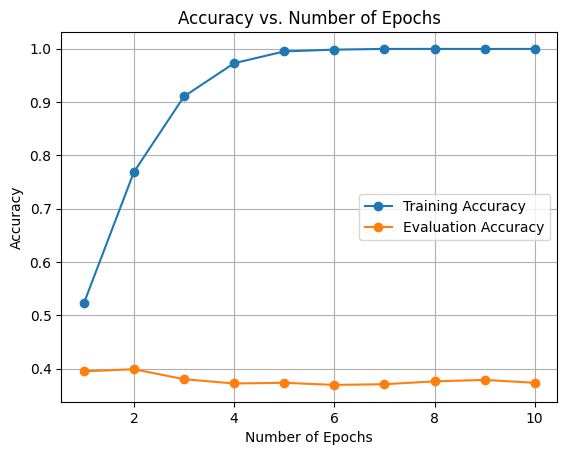

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Number of predictions differing by 1 from true labels:605/1600
              precision    recall  f1-score   support

           0     0.5836    0.5742    0.5789       310
           1     0.1949    0.2331    0.2123       163
           2     0.1901    0.2061    0.1978       131
           3     0.1546    0.1376    0.1456       109
           4     0.2222    0.1869    0.2030       107
           5     0.3040    0.3363    0.3193       113
           6     0.3362    0.2437    0.2826       160
           7     0.2557    0.3275    0.2872       171
           8     0.2937    0.2803    0.2868       132
           9     0.5784    0.5245    0.5501       204

    accuracy                         0.3469      1600
   macro avg     0.3113    0.3050    0.3064      1600
weighted avg     0.3543    0.3469    0.3488      1600



In [ ]:
# 绘制训练和验证准确度 vs. 训练周期数的图像
plt.plot(epochs_list, train_accuracy_list, marker='o', label='Training Accuracy')
plt.plot(epochs_list, eval_accuracy_list, marker='o', label='Evaluation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.legend()
plt.grid(True)

# 创建保存目录
output_dir = '/content/drive/MyDrive/Colab Notebooks/IMDB/Results'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'training_accuracy_vs_epochs.png'))
plt.show()

# 模型预测
predictions, raw_outputs = model.predict(test_df['REVIEW'].tolist())

total = len(predictions)
# 统计预测与真实标签之间差1的数量
diff_count = sum(abs(predictions - test_df['RATING']) == 1)
print(f"Number of predictions differing by 1 from true labels:{diff_count}/{total}")

# 计算评估指标
print(classification_report(test_df['RATING'], predictions, digits=4))